In [1]:
import numpy as np
import pandas as pd
from torch import nn
from phmd import datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler
from scipy.stats import kurtosis
from scipy.fft import fft
from scipy.fft import fft, fftfreq
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from tqdm import tqdm

/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
def early_prediction_score(y_true, y_pred, alpha=0.5):
    errors = y_pred - y_true
    # Heavier penalty for late predictions
    weights = np.where(errors < 0, alpha, 1)
    return np.mean(weights * errors**2)

In [3]:
TRAIN_BEARINGS = {
    1: [
        '1_1',
        # '1_2',
    ],
    2: [
        '2_1',
        '2_2',
    ],
    3: [
        '3_1',
        '3_2',
    ]
}

TEST_BEARINGS = {
    1: [
        '1_3',
        '1_4',
        '1_5',
        '1_6',
        '1_7',
    ],
    2: [
        '2_3',
        '2_4',
        '2_5',
        '2_6',
        '2_7',
    ],
    3: [
        '3_3',
    ]
}

In [4]:
dataset = datasets.Dataset('PRONOSTIA')
tasks = dataset['rul']
df = tasks.load()

Remember to cite the original publisher dataset:
	@inproceedings{nectoux2012pronostia,    
	    title={PRONOSTIA: An experimental platform for bearings accelerated degradation tests.},    
	    author={Nectoux, Patrick and Gouriveau, Rafael and Medjaher, Kamal and Ramasso, Emmanuel and Chebel-Morello, Brigitte and Zerhouni, Noureddine and Varnier, Christophe},    
	    booktitle={IEEE International Conference on Prognostics and Health Management, PHM'12.},    
	    pages={1--8},    
	    year={2012},    
	    organization={IEEE Catalog Number: CPF12PHM-CDR}    
	}
You can download the dataset manually from:  https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/

** If you find this tool useful, please cite our SoftwareX paper: 
	Solís-Martín, David, Juan Galán-Páez, and Joaquín Borrego-Díaz. "PHMD: An easy data access tool for prognosis and health management datasets." SoftwareX 29 (2025): 102039.



Reading Bearing3_3: 100%|██████████| 13959/13959 [00:35<00:00, 390.76it/s]
INFO:root:Read in 57.81956434249878 seconds


In [5]:
# train
df[0]['unit'].unique()

array(['1_1', '1_2', '2_1', '2_2', '3_1', '3_2'], dtype=object)

In [6]:
df[0].head(5)

,rul,V_acc,H_acc,unit
0,28029,-0.146,0.552,1_1
1,28029,-0.480,0.501,1_1
2,28029,0.435,0.138,1_1
3,28029,0.240,-0.423,1_1
4,28029,0.020,-0.802,1_1


In [7]:
# test
df[1]['unit'].unique()

array(['1_3', '1_4', '1_5', '1_6', '1_7', '2_3', '2_4', '2_5', '2_6',
       '2_7', '3_3'], dtype=object)

In [8]:
df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])]['unit']

0          1_1
1          1_1
2          1_1
3          1_1
4          1_1
          ... 
7175675    1_1
7175676    1_1
7175677    1_1
7175678    1_1
7175679    1_1
Name: unit, Length: 7175680, dtype: object

In [9]:
df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])]

,rul,V_acc,H_acc,unit
0,28029,-0.146,0.552,1_1
1,28029,-0.480,0.501,1_1
2,28029,0.435,0.138,1_1
3,28029,0.240,-0.423,1_1
4,28029,0.020,-0.802,1_1
...,...,...,...,...
7175675,0,2.129,-3.353,1_1
7175676,0,-2.299,-2.868,1_1
7175677,0,-1.844,-5.507,1_1
7175678,0,2.146,-3.578,1_1


In [10]:
df[1][df[1]['unit'].isin(TEST_BEARINGS[1])]

,rul,V_acc,H_acc,unit
0,23749,0.044,0.092,1_3
1,23749,0.432,-0.025,1_3
2,23749,0.008,-0.104,1_3
3,23749,-0.264,0.056,1_3
4,23749,-0.195,0.074,1_3
...,...,...,...,...
3845115,7570,-0.013,0.481,1_7
3845116,7570,-0.272,0.191,1_7
3845117,7570,0.466,0.250,1_7
3845118,7570,-0.582,0.001,1_7


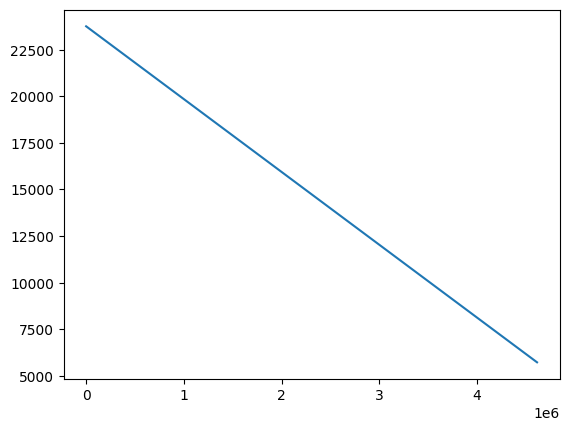

In [11]:
plt.plot(df[1][df[1]['unit'] == '1_3']['rul'])

In [12]:
# sns.kdeplot(df[0][df[0]['unit'] == '1_1']['H_acc'], label='Train')
# sns.kdeplot(test_features['h_RMS'], label='Test')
# plt.legend(); plt.show()

In [370]:
class BearingDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size=2560, step=2560 // 2):
        self.windows = []
        self.ruls = []
        
        # Create sequences
        for unit, group in df.groupby('unit'):
            h_acc =  group['H_acc'].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )
            v_acc =  group['V_acc'].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )

            rul = group['rul'].transform(lambda x: x / x.max())

            for i in range(0, len(group) - window_size, step):

                self.windows.append(np.stack([
                    h_acc[i:i+window_size], 
                    v_acc[i:i+window_size]
                ], axis=1))
                self.ruls.append(rul.values[i+window_size-1])

    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.windows[idx]), torch.FloatTensor([self.ruls[idx]])
    
train_dataset = BearingDataset(
    # [b for state in TRAIN_BEARINGS for b in TRAIN_BEARINGS[state]]
    df=df[0][df[0]['unit'].isin(['1_1'])],
)

test_dataset = BearingDataset(
    df=df[1][df[1]['unit'] == '1_3'],
)

val_dataset = BearingDataset(
    df=df[0][df[0]['unit'] == '1_2'],
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [371]:
len(train_dataset)

5604

In [395]:
class BearingCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # Feature extractor
        self.features = torch.nn.Sequential(
            # Layer 1: Wide receptive field
            torch.nn.Conv1d(2, 64, kernel_size=51, padding=25),  # (B, 2, 2560) -> (B, 64, 2560)
            torch.nn.BatchNorm1d(64),
            torch.nn.LeakyReLU(0.1),
            torch.nn.MaxPool1d(4, stride=2),  # -> (B, 64, 1278)
            
            # Layer 2: Mid-range features
            torch.nn.Conv1d(64, 128, kernel_size=25, padding=12),  # -> (B, 128, 1278)
            torch.nn.BatchNorm1d(128),
            torch.nn.LeakyReLU(0.1),
            torch.nn.MaxPool1d(4, stride=2),  # -> (B, 128, 637)
            
            # Layer 3: Local features
            torch.nn.Conv1d(128, 256, kernel_size=10, padding=5),  # -> (B, 256, 637)
            torch.nn.BatchNorm1d(256),
            torch.nn.LeakyReLU(0.1),
            torch.nn.AdaptiveAvgPool1d(1)  # -> (B, 256, 1)
        )
        
        # Regressor (fixed input dim)
        self.regressor = torch.nn.Sequential(
            torch.nn.Linear(256, 128),
            torch.nn.LayerNorm(128),  # Better for regression
            torch.nn.LeakyReLU(0.1),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(128, 1),
            # torch.nn.Sigmoid(),
            # Removed Sigmoid() for regression
        )

        # self.fc = torch.nn.Linear(128, 1)

        # with torch.no_grad():
        #     self.fc.weight.data = -torch.abs(self.fc.weight.data)
        #     self.fc.bias.data.fill_(1.0)  # Start predictions near 1.0
    
    def forward(self, x):
        # Input: (B, 2560, 2)
        x = x.permute(0, 2, 1)  # -> (B, 2, 2560)
        x = self.features(x)     # -> (B, 256, 1)
        x = x.squeeze(-1)        # -> (B, 256)
        x = self.regressor(x)  # -> (B,)
        return x

model = BearingCNN()

print(model)

BearingCNN(
  (features): Sequential(
    (0): Conv1d(2, 64, kernel_size=(51,), stride=(1,), padding=(25,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 128, kernel_size=(25,), stride=(1,), padding=(12,))
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(128, 256, kernel_size=(10,), stride=(1,), padding=(5,))
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): AdaptiveAvgPool1d(output_size=1)
  )
  (regressor): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=

In [396]:
class LogCoshLoss(nn.Module):
    def forward(self, y_pred, y_true):
        return torch.mean(torch.log(torch.cosh(y_pred - y_true)))

def weighted_mse_loss(y_pred, y_true):
    alpha=2.0
    error = y_pred - y_true
    weights = torch.where(error < 0, alpha, 1.0)  # Heavier penalty for underestimating RUL
    return torch.mean(weights * (error ** 2))

def r2_score_loss(y_pred, y_true):
    # Calculate R² (Coefficient of Determination)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / (ss_tot + 1e-8))  # Avoid division by zero
    return -r2  # Minimize this (equivalent to maximizing R²)

def hybrid_r2_mse_loss(y_pred, y_true,):
    # alpha=0.5
    alpha = 0.7
    mse = torch.mean((y_pred - y_true) ** 2)
    r2 = r2_score_loss(y_pred, y_true)  # Returns -R²
    return alpha * mse + (1 - alpha) * r2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = hybrid_r2_mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

def train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs,
):
    train_r2 = []
    train_mae = []
    train_mse = []
    train_rmse = []
    train_loss = []

    val_r2 = []
    val_mae = []
    val_mse = []
    val_rmse = []
    val_loss = []

    best_r2 = -float('inf')

    for epoch in range(epochs):
        model.train()

        epoch_train_loss = 0
        epoch_train_preds = []
        epoch_train_targets = []

        for X_batch, y_batch in tqdm(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch).flatten()

            epoch_train_preds.append(y_pred)
            epoch_train_targets.append(y_batch)

            loss = criterion(y_pred, y_batch)
            
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        train_preds = torch.cat(epoch_train_preds).cpu().detach().numpy()
        train_targets = torch.cat(epoch_train_targets).cpu().detach().numpy()
        
        epoch_train_r2 = r2_score(train_targets, train_preds)
        epoch_train_mae = mean_absolute_error(train_targets, train_preds)
        epoch_train_mse = mean_squared_error(train_targets, train_preds)
        epoch_train_rmse = np.sqrt(epoch_train_mse)
        epoch_train_loss = epoch_train_loss/len(train_loader)
        
        train_r2.append(epoch_train_r2)
        train_mae.append(epoch_train_mae)
        train_mse.append(epoch_train_mse)
        train_rmse.append(epoch_train_rmse)
        train_loss.append(epoch_train_loss)
    
        print(
            f'Epoch {epoch + 1}: Train Loss {epoch_train_loss:.4f}, '
                + f'Train R2 = {epoch_train_r2:.3f}, '
                + f'Train RMSE = {epoch_train_rmse:.3f}, '
                + f'Train MSE = {epoch_train_mse:.3f}, '
                + f'Train MAE = {epoch_train_mae:.3f}'
                # + f'Train EPS = {epoch_train_eps:.3f}'
        )


        model.eval()

        epoch_val_loss = 0
        epoch_val_preds = []
        epoch_val_targets = []

        with torch.no_grad():
            for X_val, y_val in tqdm(val_loader, desc=f'Epoch {epoch + 1} Val'):
                X_val, y_val = X_val.to(device), y_val.to(device)

                y_pred = model(X_val).flatten()

                epoch_val_preds.append(y_pred)
                epoch_val_targets.append(y_val)
                
                epoch_val_loss += criterion(y_pred, y_val).item()

        val_preds = torch.cat(epoch_val_preds).cpu().detach().numpy()
        val_targets = torch.cat(epoch_val_targets).cpu().detach().numpy()
        
        epoch_val_r2 = r2_score(val_targets, val_preds)
        epoch_val_mae = mean_absolute_error(val_targets, val_preds)
        epoch_val_mse = mean_squared_error(val_targets, val_preds)
        epoch_val_rmse = np.sqrt(epoch_val_mse)
        epoch_val_loss = epoch_val_loss/len(val_loader)
        scheduler.step(epoch_val_loss)
        
        val_r2.append(epoch_val_r2)
        val_mae.append(epoch_val_mae)
        val_mse.append(epoch_val_mse)
        val_rmse.append(epoch_val_rmse)
        val_loss.append(epoch_val_loss)

        if val_r2[-1] > best_r2:
            best_r2 = val_r2[-1]
            torch.save(model.state_dict(), 'best_r2_model.pth')

        print(
            f'Epoch {epoch + 1}: Val Loss {epoch_val_loss:.4f}, '
                + f'Val R2 = {epoch_val_r2:.3f}, '
                + f'Val RMSE = {epoch_val_rmse:.3f}, '
                + f'Val MSE = {epoch_val_mse:.3f}, '
                + f'Val MAE = {epoch_val_mae:.3f}'
        ) 

    return {
        'train_loss': train_loss,
        'train_r2': train_r2,
        'train_mae': train_mae,
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'val_loss': val_loss,
        'val_r2': val_r2,
        'val_mae': val_mae,
        'val_mse': val_mse,
        'val_rmse': val_rmse,
    }

In [397]:
train_results = train(model, train_loader, val_loader, optimizer, criterion, device, 50)

train_results

100%|██████████| 176/176 [00:04<00:00, 41.38it/s]


Epoch 1: Train Loss 105164.9901, Train R2 = 0.642, Train RMSE = 0.173, Train MSE = 0.030, Train MAE = 0.097


Epoch 1 Val: 100%|██████████| 55/55 [00:00<00:00, 166.65it/s]


Epoch 1: Val Loss 143932.8032, Val R2 = -4.124, Val RMSE = 0.653, Val MSE = 0.426, Val MAE = 0.582


100%|██████████| 176/176 [00:04<00:00, 41.17it/s]


Epoch 2: Train Loss 107722.0068, Train R2 = 0.633, Train RMSE = 0.175, Train MSE = 0.031, Train MAE = 0.095


Epoch 2 Val: 100%|██████████| 55/55 [00:00<00:00, 167.40it/s]


Epoch 2: Val Loss 124075.7784, Val R2 = -3.417, Val RMSE = 0.606, Val MSE = 0.367, Val MAE = 0.532


100%|██████████| 176/176 [00:04<00:00, 43.24it/s]


Epoch 3: Train Loss 136636.5278, Train R2 = 0.534, Train RMSE = 0.197, Train MSE = 0.039, Train MAE = 0.108


Epoch 3 Val: 100%|██████████| 55/55 [00:00<00:00, 165.71it/s]


Epoch 3: Val Loss 113967.1667, Val R2 = -3.057, Val RMSE = 0.581, Val MSE = 0.337, Val MAE = 0.504


100%|██████████| 176/176 [00:04<00:00, 42.77it/s]


Epoch 4: Train Loss 127105.5631, Train R2 = 0.570, Train RMSE = 0.189, Train MSE = 0.036, Train MAE = 0.103


Epoch 4 Val: 100%|██████████| 55/55 [00:00<00:00, 175.26it/s]


Epoch 4: Val Loss 121310.4080, Val R2 = -3.318, Val RMSE = 0.599, Val MSE = 0.359, Val MAE = 0.525


100%|██████████| 176/176 [00:04<00:00, 42.13it/s]


Epoch 5: Train Loss 141043.5434, Train R2 = 0.521, Train RMSE = 0.200, Train MSE = 0.040, Train MAE = 0.105


Epoch 5 Val: 100%|██████████| 55/55 [00:00<00:00, 172.98it/s]


Epoch 5: Val Loss 107541.2666, Val R2 = -2.828, Val RMSE = 0.564, Val MSE = 0.318, Val MAE = 0.486


100%|██████████| 176/176 [00:04<00:00, 41.98it/s]


Epoch 6: Train Loss 150096.5244, Train R2 = 0.490, Train RMSE = 0.206, Train MSE = 0.042, Train MAE = 0.110


Epoch 6 Val: 100%|██████████| 55/55 [00:00<00:00, 152.98it/s]


Epoch 6: Val Loss 114484.3404, Val R2 = -3.075, Val RMSE = 0.582, Val MSE = 0.339, Val MAE = 0.508


100%|██████████| 176/176 [00:04<00:00, 40.44it/s]


Epoch 7: Train Loss 144855.2955, Train R2 = 0.507, Train RMSE = 0.203, Train MSE = 0.041, Train MAE = 0.110


Epoch 7 Val: 100%|██████████| 55/55 [00:00<00:00, 167.97it/s]


Epoch 7: Val Loss 120982.5256, Val R2 = -3.306, Val RMSE = 0.598, Val MSE = 0.358, Val MAE = 0.522


100%|██████████| 176/176 [00:04<00:00, 37.30it/s]


Epoch 8: Train Loss 154805.6027, Train R2 = 0.479, Train RMSE = 0.208, Train MSE = 0.043, Train MAE = 0.115


Epoch 8 Val: 100%|██████████| 55/55 [00:00<00:00, 154.62it/s]


Epoch 8: Val Loss 141828.7770, Val R2 = -4.047, Val RMSE = 0.648, Val MSE = 0.420, Val MAE = 0.579


100%|██████████| 176/176 [00:04<00:00, 35.87it/s]


Epoch 9: Train Loss 159760.1245, Train R2 = 0.464, Train RMSE = 0.211, Train MSE = 0.045, Train MAE = 0.116


Epoch 9 Val: 100%|██████████| 55/55 [00:00<00:00, 157.08it/s]


Epoch 9: Val Loss 125276.0224, Val R2 = -3.456, Val RMSE = 0.609, Val MSE = 0.371, Val MAE = 0.535


100%|██████████| 176/176 [00:05<00:00, 35.07it/s]


Epoch 10: Train Loss 170321.5759, Train R2 = 0.420, Train RMSE = 0.220, Train MSE = 0.048, Train MAE = 0.120


Epoch 10 Val: 100%|██████████| 55/55 [00:00<00:00, 144.12it/s]


Epoch 10: Val Loss 110181.8559, Val R2 = -2.921, Val RMSE = 0.571, Val MSE = 0.326, Val MAE = 0.495


100%|██████████| 176/176 [00:05<00:00, 33.91it/s]


Epoch 11: Train Loss 178146.5197, Train R2 = 0.394, Train RMSE = 0.225, Train MSE = 0.050, Train MAE = 0.127


Epoch 11 Val: 100%|██████████| 55/55 [00:00<00:00, 138.80it/s]


Epoch 11: Val Loss 68581.3727, Val R2 = -1.439, Val RMSE = 0.450, Val MSE = 0.203, Val MAE = 0.363


100%|██████████| 176/176 [00:05<00:00, 34.90it/s]


Epoch 12: Train Loss 184484.7694, Train R2 = 0.375, Train RMSE = 0.228, Train MSE = 0.052, Train MAE = 0.132


Epoch 12 Val: 100%|██████████| 55/55 [00:00<00:00, 138.10it/s]


Epoch 12: Val Loss 87258.1819, Val R2 = -2.097, Val RMSE = 0.507, Val MSE = 0.258, Val MAE = 0.427


100%|██████████| 176/176 [00:05<00:00, 34.90it/s]


Epoch 13: Train Loss 201841.1096, Train R2 = 0.319, Train RMSE = 0.238, Train MSE = 0.057, Train MAE = 0.141


Epoch 13 Val: 100%|██████████| 55/55 [00:00<00:00, 142.10it/s]


Epoch 13: Val Loss 66185.5199, Val R2 = -1.344, Val RMSE = 0.441, Val MSE = 0.195, Val MAE = 0.359


100%|██████████| 176/176 [00:05<00:00, 35.17it/s]


Epoch 14: Train Loss 194088.2968, Train R2 = 0.343, Train RMSE = 0.234, Train MSE = 0.055, Train MAE = 0.140


Epoch 14 Val: 100%|██████████| 55/55 [00:00<00:00, 136.97it/s]


Epoch 14: Val Loss 72091.1355, Val R2 = -1.555, Val RMSE = 0.461, Val MSE = 0.212, Val MAE = 0.381


100%|██████████| 176/176 [00:04<00:00, 35.60it/s]


Epoch 15: Train Loss 191390.3285, Train R2 = 0.354, Train RMSE = 0.232, Train MSE = 0.054, Train MAE = 0.144


Epoch 15 Val: 100%|██████████| 55/55 [00:00<00:00, 131.42it/s]


Epoch 15: Val Loss 66050.8250, Val R2 = -1.327, Val RMSE = 0.440, Val MSE = 0.193, Val MAE = 0.365


100%|██████████| 176/176 [00:05<00:00, 32.74it/s]


Epoch 16: Train Loss 172139.5088, Train R2 = 0.423, Train RMSE = 0.219, Train MSE = 0.048, Train MAE = 0.138


Epoch 16 Val: 100%|██████████| 55/55 [00:00<00:00, 135.33it/s]


Epoch 16: Val Loss 69018.2804, Val R2 = -1.420, Val RMSE = 0.449, Val MSE = 0.201, Val MAE = 0.374


100%|██████████| 176/176 [00:05<00:00, 32.51it/s]


Epoch 17: Train Loss 165174.3617, Train R2 = 0.446, Train RMSE = 0.215, Train MSE = 0.046, Train MAE = 0.133


Epoch 17 Val: 100%|██████████| 55/55 [00:00<00:00, 136.68it/s]


Epoch 17: Val Loss 87408.9796, Val R2 = -2.080, Val RMSE = 0.506, Val MSE = 0.256, Val MAE = 0.437


100%|██████████| 176/176 [00:05<00:00, 31.49it/s]


Epoch 18: Train Loss 161617.2246, Train R2 = 0.461, Train RMSE = 0.212, Train MSE = 0.045, Train MAE = 0.133


Epoch 18 Val: 100%|██████████| 55/55 [00:00<00:00, 120.27it/s]


Epoch 18: Val Loss 70970.4400, Val R2 = -1.486, Val RMSE = 0.455, Val MSE = 0.207, Val MAE = 0.385


100%|██████████| 176/176 [00:05<00:00, 29.82it/s]


Epoch 19: Train Loss 152444.3460, Train R2 = 0.489, Train RMSE = 0.206, Train MSE = 0.043, Train MAE = 0.129


Epoch 19 Val: 100%|██████████| 55/55 [00:00<00:00, 136.25it/s]


Epoch 19: Val Loss 86305.4896, Val R2 = -2.014, Val RMSE = 0.501, Val MSE = 0.251, Val MAE = 0.436


100%|██████████| 176/176 [00:06<00:00, 29.30it/s]


Epoch 20: Train Loss 148907.8527, Train R2 = 0.499, Train RMSE = 0.204, Train MSE = 0.042, Train MAE = 0.125


Epoch 20 Val: 100%|██████████| 55/55 [00:00<00:00, 129.56it/s]


Epoch 20: Val Loss 64040.2372, Val R2 = -1.239, Val RMSE = 0.432, Val MSE = 0.186, Val MAE = 0.361


100%|██████████| 176/176 [00:05<00:00, 29.71it/s]


Epoch 21: Train Loss 108399.7993, Train R2 = 0.632, Train RMSE = 0.175, Train MSE = 0.031, Train MAE = 0.107


Epoch 21 Val: 100%|██████████| 55/55 [00:00<00:00, 130.76it/s]


Epoch 21: Val Loss 55303.3037, Val R2 = -0.886, Val RMSE = 0.396, Val MSE = 0.157, Val MAE = 0.329


100%|██████████| 176/176 [00:06<00:00, 28.45it/s]


Epoch 22: Train Loss 82453.8004, Train R2 = 0.720, Train RMSE = 0.153, Train MSE = 0.023, Train MAE = 0.094


Epoch 22 Val: 100%|██████████| 55/55 [00:00<00:00, 126.95it/s]


Epoch 22: Val Loss 85826.6401, Val R2 = -1.989, Val RMSE = 0.499, Val MSE = 0.249, Val MAE = 0.429


100%|██████████| 176/176 [00:06<00:00, 28.59it/s]


Epoch 23: Train Loss 90588.7488, Train R2 = 0.695, Train RMSE = 0.159, Train MSE = 0.025, Train MAE = 0.098


Epoch 23 Val: 100%|██████████| 55/55 [00:00<00:00, 125.08it/s]


Epoch 23: Val Loss 20325.0087, Val R2 = 0.407, Val RMSE = 0.222, Val MSE = 0.049, Val MAE = 0.161


100%|██████████| 176/176 [00:06<00:00, 26.91it/s]


Epoch 24: Train Loss 85110.8288, Train R2 = 0.713, Train RMSE = 0.155, Train MSE = 0.024, Train MAE = 0.094


Epoch 24 Val: 100%|██████████| 55/55 [00:00<00:00, 118.13it/s]


Epoch 24: Val Loss 29694.6584, Val R2 = 0.066, Val RMSE = 0.279, Val MSE = 0.078, Val MAE = 0.234


100%|██████████| 176/176 [00:06<00:00, 26.34it/s]


Epoch 25: Train Loss 69510.9396, Train R2 = 0.765, Train RMSE = 0.140, Train MSE = 0.020, Train MAE = 0.089


Epoch 25 Val: 100%|██████████| 55/55 [00:00<00:00, 125.18it/s]


Epoch 25: Val Loss 70163.8309, Val R2 = -1.311, Val RMSE = 0.438, Val MSE = 0.192, Val MAE = 0.371


100%|██████████| 176/176 [00:06<00:00, 25.62it/s]


Epoch 26: Train Loss 70059.8861, Train R2 = 0.766, Train RMSE = 0.140, Train MSE = 0.020, Train MAE = 0.084


Epoch 26 Val: 100%|██████████| 55/55 [00:00<00:00, 112.53it/s]


Epoch 26: Val Loss 50066.1018, Val R2 = -0.422, Val RMSE = 0.344, Val MSE = 0.118, Val MAE = 0.279


100%|██████████| 176/176 [00:06<00:00, 25.64it/s]


Epoch 27: Train Loss 63227.1637, Train R2 = 0.785, Train RMSE = 0.134, Train MSE = 0.018, Train MAE = 0.089


Epoch 27 Val: 100%|██████████| 55/55 [00:00<00:00, 109.85it/s]


Epoch 27: Val Loss 28870.2554, Val R2 = 0.205, Val RMSE = 0.257, Val MSE = 0.066, Val MAE = 0.203


100%|██████████| 176/176 [00:07<00:00, 24.21it/s]


Epoch 28: Train Loss 72913.6855, Train R2 = 0.757, Train RMSE = 0.142, Train MSE = 0.020, Train MAE = 0.082


Epoch 28 Val: 100%|██████████| 55/55 [00:00<00:00, 116.80it/s]


Epoch 28: Val Loss 71118.0365, Val R2 = -1.192, Val RMSE = 0.427, Val MSE = 0.182, Val MAE = 0.351


100%|██████████| 176/176 [00:06<00:00, 25.44it/s]


Epoch 29: Train Loss 58113.9857, Train R2 = 0.804, Train RMSE = 0.128, Train MSE = 0.016, Train MAE = 0.081


Epoch 29 Val: 100%|██████████| 55/55 [00:00<00:00, 108.78it/s]


Epoch 29: Val Loss 28001.5726, Val R2 = 0.197, Val RMSE = 0.258, Val MSE = 0.067, Val MAE = 0.194


100%|██████████| 176/176 [00:07<00:00, 24.51it/s]


Epoch 30: Train Loss 214817.4729, Train R2 = 0.292, Train RMSE = 0.243, Train MSE = 0.059, Train MAE = 0.175


Epoch 30 Val: 100%|██████████| 55/55 [00:00<00:00, 115.42it/s]


Epoch 30: Val Loss 67989.4561, Val R2 = -1.053, Val RMSE = 0.413, Val MSE = 0.171, Val MAE = 0.351


100%|██████████| 176/176 [00:07<00:00, 23.52it/s]


Epoch 31: Train Loss 107230.7887, Train R2 = 0.665, Train RMSE = 0.167, Train MSE = 0.028, Train MAE = 0.128


Epoch 31 Val: 100%|██████████| 55/55 [00:00<00:00, 110.27it/s]


Epoch 31: Val Loss 146689.1715, Val R2 = -3.812, Val RMSE = 0.633, Val MSE = 0.400, Val MAE = 0.599


100%|██████████| 176/176 [00:07<00:00, 24.00it/s]


Epoch 32: Train Loss 85989.8782, Train R2 = 0.733, Train RMSE = 0.149, Train MSE = 0.022, Train MAE = 0.115


Epoch 32 Val: 100%|██████████| 55/55 [00:00<00:00, 113.08it/s]


Epoch 32: Val Loss 187077.3327, Val R2 = -5.231, Val RMSE = 0.720, Val MSE = 0.518, Val MAE = 0.690


100%|██████████| 176/176 [00:07<00:00, 24.26it/s]


Epoch 33: Train Loss 73154.6644, Train R2 = 0.771, Train RMSE = 0.138, Train MSE = 0.019, Train MAE = 0.105


Epoch 33 Val: 100%|██████████| 55/55 [00:00<00:00, 109.28it/s]


Epoch 33: Val Loss 179293.8752, Val R2 = -4.949, Val RMSE = 0.703, Val MSE = 0.495, Val MAE = 0.673


100%|██████████| 176/176 [00:07<00:00, 24.28it/s]


Epoch 34: Train Loss 63729.3953, Train R2 = 0.796, Train RMSE = 0.130, Train MSE = 0.017, Train MAE = 0.101


Epoch 34 Val: 100%|██████████| 55/55 [00:00<00:00, 114.68it/s]


Epoch 34: Val Loss 204548.2679, Val R2 = -5.866, Val RMSE = 0.756, Val MSE = 0.571, Val MAE = 0.726


100%|██████████| 176/176 [00:07<00:00, 24.02it/s]


Epoch 35: Train Loss 53927.2693, Train R2 = 0.821, Train RMSE = 0.122, Train MSE = 0.015, Train MAE = 0.092


Epoch 35 Val: 100%|██████████| 55/55 [00:00<00:00, 109.76it/s]


Epoch 35: Val Loss 200396.1467, Val R2 = -5.726, Val RMSE = 0.748, Val MSE = 0.559, Val MAE = 0.718


100%|██████████| 176/176 [00:07<00:00, 22.85it/s]


Epoch 36: Train Loss 55490.0337, Train R2 = 0.824, Train RMSE = 0.121, Train MSE = 0.015, Train MAE = 0.096


Epoch 36 Val: 100%|██████████| 55/55 [00:00<00:00, 107.08it/s]


Epoch 36: Val Loss 224261.6214, Val R2 = -6.556, Val RMSE = 0.793, Val MSE = 0.628, Val MAE = 0.763


100%|██████████| 176/176 [00:07<00:00, 23.24it/s]


Epoch 37: Train Loss 48261.9410, Train R2 = 0.845, Train RMSE = 0.113, Train MSE = 0.013, Train MAE = 0.087


Epoch 37 Val: 100%|██████████| 55/55 [00:00<00:00, 94.54it/s]


Epoch 37: Val Loss 221530.7821, Val R2 = -6.455, Val RMSE = 0.787, Val MSE = 0.620, Val MAE = 0.758


100%|██████████| 176/176 [00:07<00:00, 22.94it/s]


Epoch 38: Train Loss 46650.3732, Train R2 = 0.849, Train RMSE = 0.112, Train MSE = 0.013, Train MAE = 0.085


Epoch 38 Val: 100%|██████████| 55/55 [00:00<00:00, 105.98it/s]


Epoch 38: Val Loss 204869.6678, Val R2 = -5.865, Val RMSE = 0.756, Val MSE = 0.571, Val MAE = 0.724


100%|██████████| 176/176 [00:07<00:00, 23.71it/s]


Epoch 39: Train Loss 45315.7974, Train R2 = 0.846, Train RMSE = 0.113, Train MSE = 0.013, Train MAE = 0.084


Epoch 39 Val: 100%|██████████| 55/55 [00:00<00:00, 112.46it/s]


Epoch 39: Val Loss 198227.5648, Val R2 = -5.631, Val RMSE = 0.743, Val MSE = 0.551, Val MAE = 0.711


100%|██████████| 176/176 [00:07<00:00, 22.97it/s]


Epoch 40: Train Loss 43072.4511, Train R2 = 0.858, Train RMSE = 0.109, Train MSE = 0.012, Train MAE = 0.083


Epoch 40 Val: 100%|██████████| 55/55 [00:00<00:00, 99.74it/s] 


Epoch 40: Val Loss 191709.0916, Val R2 = -5.400, Val RMSE = 0.730, Val MSE = 0.532, Val MAE = 0.697


100%|██████████| 176/176 [00:07<00:00, 22.02it/s]


Epoch 41: Train Loss 42100.1152, Train R2 = 0.862, Train RMSE = 0.107, Train MSE = 0.011, Train MAE = 0.081


Epoch 41 Val: 100%|██████████| 55/55 [00:00<00:00, 108.45it/s]


Epoch 41: Val Loss 186712.5683, Val R2 = -5.223, Val RMSE = 0.719, Val MSE = 0.517, Val MAE = 0.686


100%|██████████| 176/176 [00:08<00:00, 21.85it/s]


Epoch 42: Train Loss 43386.4609, Train R2 = 0.862, Train RMSE = 0.107, Train MSE = 0.011, Train MAE = 0.080


Epoch 42 Val: 100%|██████████| 55/55 [00:00<00:00, 102.93it/s]


Epoch 42: Val Loss 188945.1915, Val R2 = -5.303, Val RMSE = 0.724, Val MSE = 0.524, Val MAE = 0.691


100%|██████████| 176/176 [00:08<00:00, 20.90it/s]


Epoch 43: Train Loss 39714.6591, Train R2 = 0.867, Train RMSE = 0.105, Train MSE = 0.011, Train MAE = 0.080


Epoch 43 Val: 100%|██████████| 55/55 [00:00<00:00, 101.93it/s]


Epoch 43: Val Loss 188204.3330, Val R2 = -5.277, Val RMSE = 0.722, Val MSE = 0.522, Val MAE = 0.690


100%|██████████| 176/176 [00:08<00:00, 21.12it/s]


Epoch 44: Train Loss 40538.6036, Train R2 = 0.870, Train RMSE = 0.104, Train MSE = 0.011, Train MAE = 0.078


Epoch 44 Val: 100%|██████████| 55/55 [00:00<00:00, 94.62it/s]


Epoch 44: Val Loss 187519.0420, Val R2 = -5.252, Val RMSE = 0.721, Val MSE = 0.520, Val MAE = 0.688


100%|██████████| 176/176 [00:08<00:00, 21.19it/s]


Epoch 45: Train Loss 46905.7551, Train R2 = 0.857, Train RMSE = 0.109, Train MSE = 0.012, Train MAE = 0.081


Epoch 45 Val: 100%|██████████| 55/55 [00:00<00:00, 100.51it/s]


Epoch 45: Val Loss 186209.3583, Val R2 = -5.206, Val RMSE = 0.718, Val MSE = 0.516, Val MAE = 0.685


100%|██████████| 176/176 [00:08<00:00, 21.16it/s]


Epoch 46: Train Loss 43381.0706, Train R2 = 0.862, Train RMSE = 0.107, Train MSE = 0.011, Train MAE = 0.081


Epoch 46 Val: 100%|██████████| 55/55 [00:00<00:00, 99.10it/s] 


Epoch 46: Val Loss 185926.4141, Val R2 = -5.196, Val RMSE = 0.718, Val MSE = 0.515, Val MAE = 0.685


100%|██████████| 176/176 [00:08<00:00, 21.26it/s]


Epoch 47: Train Loss 41436.8123, Train R2 = 0.864, Train RMSE = 0.106, Train MSE = 0.011, Train MAE = 0.080


Epoch 47 Val: 100%|██████████| 55/55 [00:00<00:00, 97.67it/s] 


Epoch 47: Val Loss 185408.9236, Val R2 = -5.178, Val RMSE = 0.717, Val MSE = 0.514, Val MAE = 0.684


100%|██████████| 176/176 [00:08<00:00, 20.88it/s]


Epoch 48: Train Loss 40976.0778, Train R2 = 0.863, Train RMSE = 0.107, Train MSE = 0.011, Train MAE = 0.081


Epoch 48 Val: 100%|██████████| 55/55 [00:00<00:00, 96.71it/s]


Epoch 48: Val Loss 185628.3906, Val R2 = -5.186, Val RMSE = 0.717, Val MSE = 0.514, Val MAE = 0.684


100%|██████████| 176/176 [00:09<00:00, 18.00it/s]


Epoch 49: Train Loss 41343.3753, Train R2 = 0.862, Train RMSE = 0.107, Train MSE = 0.011, Train MAE = 0.080


Epoch 49 Val: 100%|██████████| 55/55 [00:00<00:00, 98.01it/s]


Epoch 49: Val Loss 185574.9574, Val R2 = -5.184, Val RMSE = 0.717, Val MSE = 0.514, Val MAE = 0.684


100%|██████████| 176/176 [00:09<00:00, 18.32it/s]


Epoch 50: Train Loss 39964.0290, Train R2 = 0.869, Train RMSE = 0.104, Train MSE = 0.011, Train MAE = 0.079


Epoch 50 Val: 100%|██████████| 55/55 [00:00<00:00, 93.78it/s]

Epoch 50: Val Loss 185506.4244, Val R2 = -5.182, Val RMSE = 0.717, Val MSE = 0.514, Val MAE = 0.684


{'train_loss': [105164.99014004794,
  107722.00683732466,
  136636.52776544745,
  127105.56311312589,
  141043.54344315964,
  150096.52437799628,
  144855.29551835495,
  154805.60268887607,
  159760.1245172674,
  170321.57593328302,
  178146.51969216086,
  184484.7693980824,
  201841.10957475143,
  194088.2968084162,
  191390.3285328258,
  172139.50877241654,
  165174.3616582697,
  161617.2245871804,
  152444.34598055753,
  148907.85265974564,
  108399.79931224477,
  82453.80036232689,
  90588.74879732999,
  85110.82878667657,
  69510.9396126487,
  70059.88607788086,
  63227.16371154785,
  72913.68551774458,
  58113.9856782393,
  214817.47288097034,
  107230.78869074042,
  85989.87822376598,
  73154.66443425958,
  63729.395283092155,
  53927.26927601208,
  55490.03374134411,
  48261.940992875534,
  46650.37316894531,
  45315.79741044478,
  43072.45113580877,
  42100.1152232777,
  43386.46087923917,
  39714.65908258611,
  40538.60359330611,
  46905.75513250178,
  43381.07057883523,
  41

In [398]:
def plot_training_history(loss_history, metric_history=None):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Training Loss')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Metrics plot
    if metric_history:
        plt.subplot(1, 2, 2)
        for metric_name, values in metric_history.items():
            plt.plot(values, label=metric_name)
        plt.title('Training Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Metric Value')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actuals(y_true, y_pred, title='Predictions vs True Values'):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='True Values', linewidth=2)
    plt.plot(y_pred, label='Predictions', linestyle='--')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()



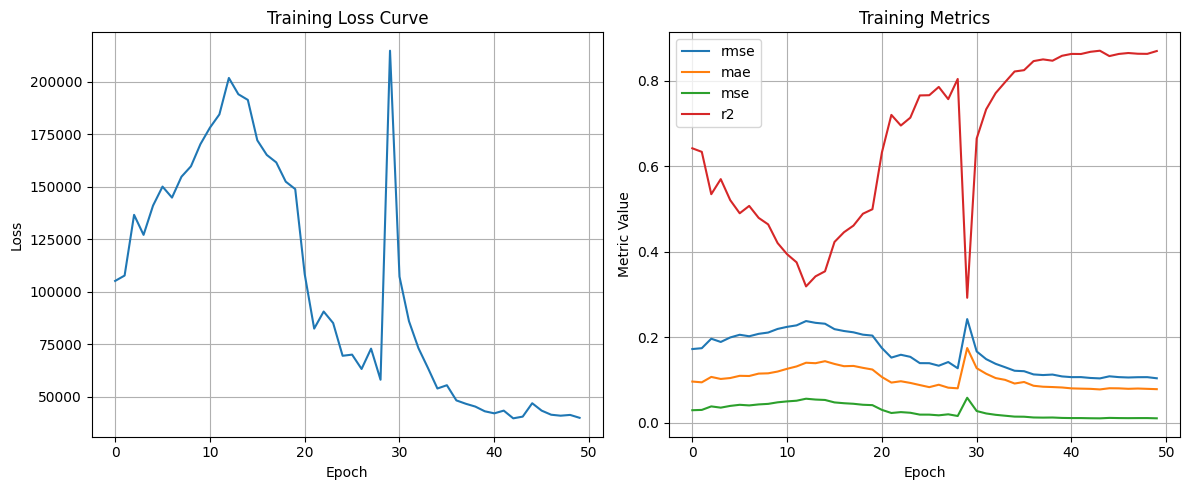

In [399]:
plot_training_history(
    train_results['train_loss'],
    {
        'rmse': train_results['train_rmse'],
        'mae': train_results['train_mae'],
        'mse': train_results['train_mse'],
        'r2': train_results['train_r2'],
    }
)

In [377]:
len(test_loader)

113

In [400]:
# model.load_state_dict(torch.load('best_r2_model.pth', weights_only=True))

def test(
    model,
    test_loader,
    device,
):
    model.eval()

    test_preds = []
    test_targets = []

    test_r2 = []
    test_mae = []
    test_mse = []
    test_rmse = []
    
    with torch.no_grad():
        for data, labels in tqdm(test_loader):
            data = data.to(device)
            labels = labels.to(device)
            predictions = model(data).flatten()
            
            # predictions = torch.cummin(predictions.flip(0), dim=0).values.flip(-1)

            test_preds.append(predictions)
            test_targets.append(labels)

        test_preds = torch.cat(test_preds).cpu().detach().numpy()
        test_targets = torch.cat(test_targets).cpu().detach().numpy()

        mse = mean_squared_error(test_targets, test_preds)

        test_r2.append(r2_score(test_targets, test_preds))
        test_mae.append(mean_absolute_error(test_targets, test_preds))
        test_mse.append(mse)
        test_rmse.append(np.sqrt(mse))

    return {
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_preds': test_preds,
        'test_targets': test_targets,
    }
          

In [401]:
test_results = test(model, test_loader, device)

test_results

100%|██████████| 113/113 [00:00<00:00, 174.95it/s]


{'test_r2': [-1.500522988222965],
 'test_mae': [0.31732255],
 'test_mse': [0.119835734],
 'test_rmse': [0.346173],
 'test_preds': array([ 1.0611112 ,  1.1102574 ,  1.116568  , ...,  0.15258333,
        -0.00948305, -0.01341332], dtype=float32),
 'test_targets': array([[0.99962103],
        [0.9994105 ],
        [0.9992    ],
        ...,
        [0.24190493],
        [0.24169439],
        [0.24148385]], dtype=float32)}

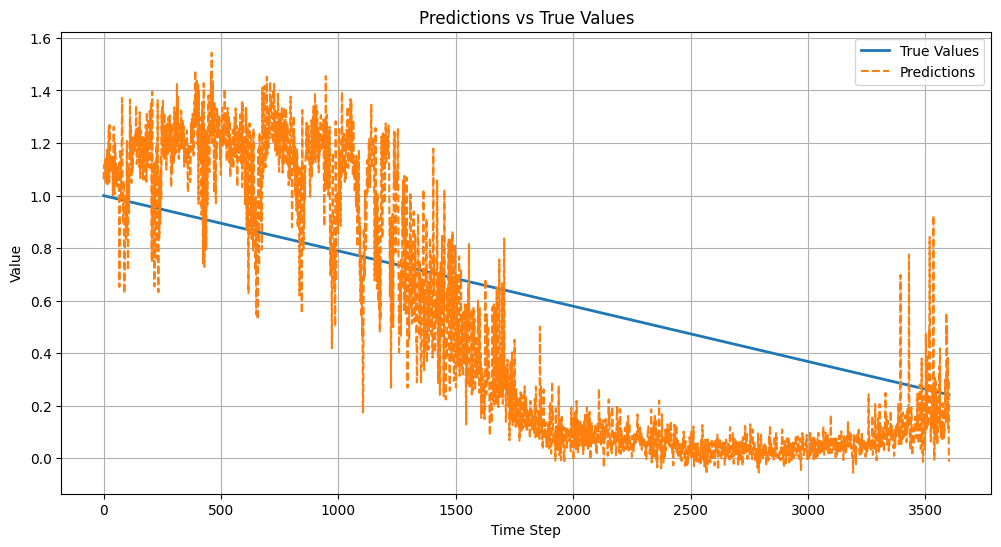

In [403]:
plot_predictions_vs_actuals(
    test_results['test_targets'],
    test_results['test_preds']
)

In [ ]:
test_results['test_targets']

(4602, 1)

In [300]:
test_results['test_preds']

array([0.02777791, 0.02777791, 0.02777791, ..., 0.02777791, 0.02777791,
       0.02777791], dtype=float32)

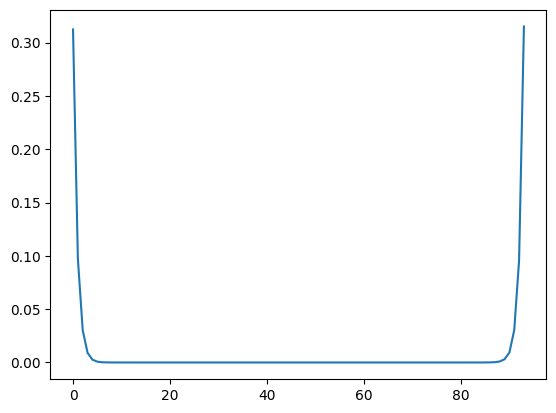

In [151]:
plt.plot(test_results['rul'].cpu().numpy())